In [1]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from keras.models import load_model
import tensorflow.keras.backend as K
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import tensorflow as tf
import numpy as np
import matplotlib 
import time
import keras
import os
from data_generation import *
from batch_creator import *
from gp_kernels import *
from gp_priors import *
from gp_plots import *

Using TensorFlow backend.


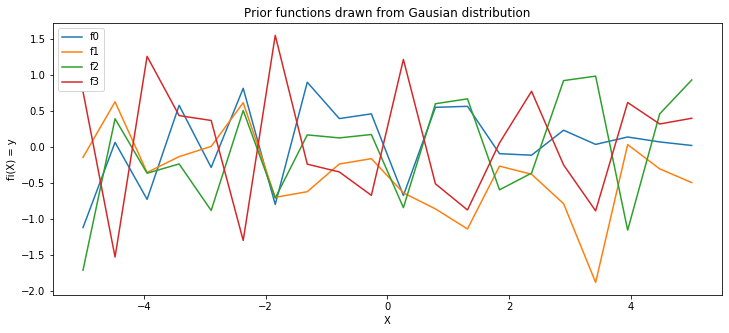

In [2]:
plot_gp_prior(4, n=20)

In [3]:
def create_batch_gp_mim_2(pos, tar, pos_mask, batch_s=128):
    '''
    Get a batch of positions, targets and position mask from data generated 
    by data_generator_for_gp_mimick_gpt function and from position_mask function 
    -------------------------
    Parameters:
    pos (2D np array): 1st/2nd output from data_generator_for_gp_mimick_gpt function 
    tar (2D np array): 3rd/4th output from data_generator_for_gp_mimick_gpt function  
    pos_mask (4D np.array): output from position_mask function 
    batch_s (int): deafult 128
    -------------------------
    Returns:
    batch_tar_tr (2D np array)
    batch_pos_tr (2D np array)
    batch_pos_mask (4D np array)
    batch_idx_tr (1D np array): indices (=row numbers) chosen for current batch
    
    '''
    shape = tar.shape[0]
    batch_idx_tr = np.random.choice(list(range(shape)), batch_s)
    batch_tar_tr = tar[batch_idx_tr, :]
    batch_pos_tr = pos[batch_idx_tr, :]
    batch_pos_mask = pos_mask[batch_idx_tr, :, :, :]
    return batch_tar_tr, batch_pos_tr, batch_pos_mask, batch_idx_tr

In [4]:
def data_generator_for_gp_mimick_gpt(num_obs, kernel, tr_percent=0.8):
    '''
    Generator for training a GPT inspired netowrk. Make sure x is drawn in a range that 
    Doesn't include 0 --> 0 is used for padding.
    -----------------------
    Parameters:
    num_obs (int): how many observation to generate
    kernel (function of am SKlearn kernel object): e.g. rbf_kernel which comes from gp_kernels file
    tr_percent (float): daefult 0.8
    -----------------------
    Returns:
    pad_pos_tr (np array): the first rows * tr_percent from the x generated values padded by zeros according to obs_per_sample  
    pad_pos_te (np array): all rows of x not chosen for training 
    pad_y_fren_tr (np array): the first rows * tr_percent from the f_prior generated values padded by zeros according to obs_per_sample  
    pad_y_fren_te (np array): all rows of f_prior not chosen for training 
    '''
    df = np.zeros((num_obs * 2, 59))
    for i in range(0, num_obs * 2, 2):
        x = np.random.uniform(5, 15, size=(1, 59))
        k = kernel(x)
        f_prior = generate_priors(k, 59, 1)

        df[i, :x.shape[1]] = x
        df[i + 1, :x.shape[1]] = f_prior

    rows = df.shape[0]
    cols = df.shape[1]
    tr_rows = int(tr_percent * rows)
    tr_rows = tr_rows if tr_rows % 2 == 0 else tr_rows + 1
    df_tr = df[:tr_rows, :]
    df_te = df[tr_rows:, :]
    
    # get all even rows
    pad_pos_tr = df_tr[::2, :]
    pad_pos_te = df_te[::2, :]
    # get all odd rows
    pad_y_fren_tr = df_tr[1::2, :]
    pad_y_fren_te = df_te[1::2, :]

    return pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, df_tr, df_te

In [5]:
def position_mask(arr):
    '''
    This tries to emulate the kernel matrix. 
    In the first stage we have a 2X2 matrix of zeros, next
    3X3 matrix of zeros, etc.
    -------------------------
    Parameters:
    arr (np array): the 1st/2nd output from data_generator_for_gp_mimick_gpt function
    -------------------------
    Returns:
    mask (4D np array): if there are 100 rows and 50 cols in arr then this will 
    return [100, 49, 50, 50] array -- where the first dim is observation number 
    second dim is timestamp and third+fourth dim are the mask matrix.
    '''
    rows = arr.shape[0]
    cols = arr.shape[1]
    mask = np.ones((rows, cols - 1, cols, cols))
    specific = np.sum(np.equal(arr, 0), 1)
    for i in range(2, cols + 1):
        mask[:, i - 2, :i, :i] = np.zeros((i, i))
    for j in range(rows):
        k  = specific[j]
        mask[j, k:, :, :] = 1
            
    return mask

In [6]:
def create_padding_mask(seq):
    '''
    Used to pad sequences that have zeros where there was no event.
    Typically this will be combined with create_look_ahead_mask function.
    This function is used inside an open session of tensorflow. 
    To try it out create a tf.constant tensor.
    -------------------
    Parameters:
    seq (tensor): shape is (batch_size, seq_len)
    
    -------------------
    Returns:
    A binary tensor  (batch_size, 1, seq_len): 1 where there was no event and 0 otherwise.
    
    '''
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention. Extra dimension is used in create_masks function
    return seq[:, tf.newaxis, :]  

In [7]:
def create_tar_mask(size):
    '''
    '''
    mask = tf.linalg.diag(tf.ones(size, size))
    return mask

In [8]:
create_tar_mask(3)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=int32)>

In [9]:
def create_look_ahead_mask(size):
    '''
    Hide future outputs from a decoder style network.
    Used typically together with create_padding_mask function
    -----------------------
    Parameters:
    size (int): max sequnce length 
    
    -----------------------
    Returns:
    mask (tensor): shape is (seq_len X seq_len). Example: if size is 4, returns
    0 1 1 1
    0 0 1 1
    0 0 0 1
    0 0 0 0 
    where 1 signifies what to hide.
    '''
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [10]:
def create_masks(tar):
    '''
    Create unified masking hiding future from current timestamps and hiding paddings. 
    -------------------
    Parameters: 
    tar (tensor): batch of padded target sequences 
    -------------------
    Returns: 
    combined_mask_tar  (tensor): shape is batch_size X max_seq_len X max_seq_len
    '''
    
    tar_padding_mask = create_padding_mask(tar)
    ## this will be batch_size X 1 X 40

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    # if max seq length is 40 -- > this will be 40X40 
    
    
    ## This will also be (64, 40, 40)
    combined_mask_tar = tf.maximum(tar_padding_mask, look_ahead_mask)
    
    
    return combined_mask_tar

In [11]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generator_for_gp_mimick_gpt(10000, rbf_kernel)

In [12]:
pp = position_mask(pad_pos_tr)

In [13]:
loss_object = tf.keras.losses.MeanSquaredError()

In [14]:
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [15]:
def loss_function(real, pred):
    '''
    Masked MSE. Since the target sequences are padded, 
    it is important to apply a padding mask when calculating the loss.
    ----------------
    Parameters:
    real (tf.tensor float64): shape batch_size X max_seq_len. True values of sequences.
    pred (tf.tensor float64): shape batch_size X max_seq_len. Predictions from GPT network. 
    
    ----------------
    Returns: 
    loss value (tf.float64)
    '''
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
#     print('loss_ :', loss_)
#     shape= (128X58)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [23]:
def dot_prod_position(q, k, v, mask):
    '''
    Used to create a pseudo XX^T covariance matrix for each 
    positional sequence in the batch.
    ------------------
    Parameters: 
    q : shape (batch_size X max_seq_len X 1). Position outptut from create_batch_gp_mim_2 function (or after another Dense layer) 
    k : shape (batch_size X max_seq_len X 1). Position outptut from create_batch_gp_mim_2 function (or after another Dense layer) 
    mask: shape (batch_size X max_seq_len X max_seq_len X max_seq_len). The positional mask created by position_mask function and selected in batch indices 
    
    ------------------
    Returns:
    nl_qk (tf.tensor float64): shape (batch_size X max_seq_len X max_seq_len X max_seq_len).
    Each observation (1st dim) has seq_len timestamps (2nd dim) and each timestamp has an associated
    seq_len X seq_len pseudo covariance matrix (3rd & 4th dims) masked according to the timestamp.
    
    '''
    qk = tf.matmul(q, k, transpose_b = True)
    qk = tf.cast(qk[:, tf.newaxis, :, :], tf.float64)
#     print('qk1: ', qk)
#     shape=(128, 1, 59, 59)

#     print('pos_mask: ', mask)
#     shape=(128, 58, 59, 59)
    if mask is not None:
        qk +=  ((tf.cast(mask, tf.float64)) * -1e9)
        
#     print('qk2: ', qk)
# shape=(128, 58, 59, 59)

    qk = tf.reshape(qk, shape = [tf.shape(mask)[0], tf.shape(mask)[1], -1])
    
#     print('qk3: ', qk)
#     shape=(128, 58, 3481)
    
    qk = tf.reshape(tf.nn.softmax(qk, axis = -1), shape = [tf.shape(mask)[0], tf.shape(mask)[1], tf.shape(mask)[2], tf.shape(mask)[3]])
    
#     print('qk4: ', qk)
    #shape=(128, 58, 59, 59)
    
    v = tf.cast(v[:, tf.newaxis, :, :], tf.float64)
    
    u = tf.transpose(tf.matmul(qk, v), perm = [0, 1, 3 ,2])
    
#     print('u: ', u)
#     shape=(128, 58, 16, 59)
    
    u2 = tf.matmul(u, v)
    
    
    return u2

In [24]:
def dot_product_attention(q, k, v, mask):
    '''
    Attention inspired by Transformer (but not the same). The Transformer embeds the 
    target words to q (query), k (key), v (value). So if we have a batch of 128 sequences 
    with max length 40 and embedding layer is 20, we will get shape q = shape k = shape v
    = (128 X  max sequence length X 20). The Transformer then transposes k 
    to get after matmul (128 X max seq X max seq) matrix. We then apply relu layer (unlike in Transformer)
    ---------------------
    Parameters:
    q (tf.tensor float64): shape (batch_size, max_seq_len, 1)
    k (tf.tensor float64): shape (batch_size, max_seq_len, 1)
    v (tf.tensor float64): shape (batch_size, max_seq_len, 1)
    mask (tf.tensor float64): shape (batch_size, max_seq_len, max_seq_len)
    ---------------------
    Returns:
    out_tar: shape (batch_size, max_seq_len, max_seq_len). The sequences after embedding (or Dense layer) weighted by attention_weights. 
    attention_weights : shape (batch_size, max_seq_len, max_seq_len). Weights to assign for each sequence member at each timestamp (2nd dim).
    matmul_qk: shape (batch_size, max_seq_len, max_seq_len)
    
    
    '''
    # similarity
    # q = k = v  shape := (batch_size, max_seq_len - 1, max_seq_len -1)
    matmul_qk = tf.matmul(q, k, transpose_b = True, name = 'qk')
#     print('matmul_qk: ', matmul_qk)
#     shape=(128, 58, 58)
    
    nl_qk = tf.cast(tf.nn.relu(matmul_qk, name = 'nl_qk'), tf.float64) 
#     print('nl_qk: ', nl_qk)
#     shape=(128, 58, 58)
#     nl_qk shape := (batch_size, max_seq_len - 1, max_seq_len - 1)

    # -1e9 will turn the softmax output in this locations to zero
    # this is a good mask as an input for softmax -- we need also masking when 
    # want to use matmul as is 
    
    if mask is not None:
        nl_qk +=  ((tf.cast(mask, tf.float64)) * -1e9)
    
        
#     print('nl_qk after mask: ', nl_qk)
#     shape=(128, 58, 58)
        
     # turn simialrity to scores
    attention_weights = tf.nn.softmax(nl_qk, axis = -1, name = 'attention_weights')
    # Notice that for all the rows where 
    # everything is 0, the masking will turn everything to -inf
    # and the output from the softmax would be 1/num_cols 
    # (try a = tf.constant([-1e9, -1e9, -1e9]), tf.nn.softmax(a))
    # So we can expect an output from these rows which we want to ignore
    # this will be enforced in the masking of the loss function 
    
#     print('attention_weights: ', attention_weights)
#     shape=(128, 58, 58)
   
    # weight values 
    # attention_weights shape := (batch_size, max_seq_len - 1, max_seq_len - 1), 
    # v shape := batch_size X max_seq_len X l
    out_tar = tf.matmul(attention_weights, v)
    
#   print('out_tar: ', out_tar)
#   shape=(128, 58, tar_d_model)
    
    return out_tar, attention_weights, matmul_qk

In [25]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, l):
        super(Decoder, self).__init__()
        
        self.l = l
        
        self.wq = tf.keras.layers.Dense(l, name = 'wq')
        self.wk = tf.keras.layers.Dense(l, name = 'wk')
        self.wv = tf.keras.layers.Dense(l, name = 'wk')                    
        
        self.hq = tf.keras.layers.Dense(l, name = 'hq')
        self.hk = tf.keras.layers.Dense(l, name = 'hk')
        self.hv = tf.keras.layers.Dense(l, name = 'hv')
        
        self.B = tf.keras.layers.Dense(l, name = 'B')
        self.A = tf.keras.layers.Dense(1, name = 'A')

    #a call method, the layer's forward pass
    def call(self, tar_position, tar_inp, training, pos_mask, tar_mask):
        
        # Adding extra dimension to allow multiplication of 
        # a sequnce with itself. 
        tar_position = tar_position[:, :, tf.newaxis]
        
        q_p = self.wq(tar_position) 
        k_p = self.wk(tar_position)
        v_p = self.wk(tar_position)


#         print('v_p: ', v_p)
        #shape=(128, 59, 16)
        
        pos_attn1 = dot_prod_position(q_p, k_p, v_p, mask = pos_mask)
#         print('pos_attn1 :', pos_attn1)
#       shape=(128, 58, 16, 16)
    
        tar_inp = tar_inp[:, :, tf.newaxis]

        
        q = self.hq(tar_inp) 
        k = self.hk(tar_inp)
        v = self.hv(tar_inp)
        
#         print('q :', q)
#       shape=(128, 58, 16)

        tar_attn1, _, _ = dot_product_attention(q, k, v, tar_mask)
        # tar_attn1 is (batch_size, max_seq_len - 1, tar_d_model)

#         print('tar_attn1 :', tar_attn1)
#       shape=(128, 58, l)
#       shape=(128, 58, 16)
        tar_attn1 = tar_attn1[:, :, :, tf.newaxis]
        
        tar1 = self.B(tar_attn1)
        
#         print('tar1 :', tar1)
        # shape=(128, 58, 16, 16)

        L = tf.matmul(tar1, pos_attn1)
        
#         print('L :', L)
        # shape=(128, 58, 16, 16)
        
        L2 = self.A(tf.reshape(L, shape = [tf.shape(L)[0], tf.shape(L)[1] ,self.l ** 2])) 
        
#         print('L2 :', L2)
      # shape=(128, 58, 1)  
        
        return tf.squeeze(L2)

In [26]:
decoder = Decoder(16)

In [27]:
@tf.function
def train_step(pos, tar, pos_mask):
    '''
    A typical train step function for TF2. Elements which we wish to track their gradient
    has to be inside the GradientTape() clause. see (1) https://www.tensorflow.org/guide/migrate 
    (2) https://www.tensorflow.org/tutorials/quickstart/advanced
    ------------------
    Parameters:
    pos (np array): array of positions (x values) - the 1st/2nd output from data_generator_for_gp_mimick_gpt
    tar (np array): array of targets. Notice that if dealing with sequnces, we typically want to have the targets go from 0 to n-1. The 3rd/4th output from data_generator_for_gp_mimick_gpt  
    pos_mask (np array): see description in position_mask function
    ------------------    
    '''
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    combined_mask_tar = create_masks(tar_inp)
    with tf.GradientTape(persistent=True) as tape:
        pred = decoder(pos, tar_inp, True, pos_mask, combined_mask_tar)
#         print('pred: ')
#         tf.print(pred)

        loss = loss_function(tar_real, pred)

    gradients = tape.gradient(loss, decoder.trainable_variables)
#     tf.print(gradients)
    optimizer.apply_gradients(zip(gradients, decoder.trainable_variables))
    train_loss(loss)
    b = decoder.trainable_weights[0]
#     tf.print(tf.reduce_mean(b))

In [28]:
tf.keras.backend.set_floatx('float64')

In [29]:
if __name__ == '__main__':
    EPOCHS = 200
    batch_s  = 128
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    
    for epoch in range(EPOCHS):
        start = time.time()
#         train_loss.reset_states()

        for batch in range(num_batches):
            batch_tar_tr, batch_pos_tr, batch_pos_mask, _ = create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, pp)
            # batch_tar_tr shape := 128 X 59 = (batch_size, max_seq_len)
            # batch_pos_tr shape := 128 X 59 = (batch_size, max_seq_len)
            train_step(batch_pos_tr, batch_tar_tr, batch_pos_mask)

            if batch % 50 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                  epoch + 1, batch, train_loss.result()))

        print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 99.5025
Epoch 1 Batch 50 Loss 7.9887
Time taken for 1 epoch: 51.6591260433197 secs

Epoch 2 Batch 0 Loss 6.4683
Epoch 2 Batch 50 Loss 3.6079
Time taken for 1 epoch: 50.67109179496765 secs

Epoch 3 Batch 0 Loss 3.2618
Epoch 3 Batch 50 Loss 2.3308
Time taken for 1 epoch: 52.302149295806885 secs

Epoch 4 Batch 0 Loss 2.1814
Epoch 4 Batch 50 Loss 1.7219
Time taken for 1 epoch: 52.55574083328247 secs

Epoch 5 Batch 0 Loss 1.6391
Epoch 5 Batch 50 Loss 1.3655
Time taken for 1 epoch: 52.70015001296997 secs

Epoch 6 Batch 0 Loss 1.3130
Epoch 6 Batch 50 Loss 1.1315
Time taken for 1 epoch: 52.165884256362915 secs

Epoch 7 Batch 0 Loss 1.0952
Epoch 7 Batch 50 Loss 0.9662
Time taken for 1 epoch: 51.46593403816223 secs

Epoch 8 Batch 0 Loss 0.9396
Epoch 8 Batch 50 Loss 0.8431
Time taken for 1 epoch: 51.53605675697327 secs

Epoch 9 Batch 0 Loss 0.8228
Epoch 9 Batch 50 Loss 0.7479
Time taken for 1 epoch: 51.36889886856079 secs

Epoch 10 Batch 0 Loss 0.7319
Epoch 10 Batch 50 Loss 0

Epoch 78 Batch 0 Loss 0.0885
Epoch 78 Batch 50 Loss 0.0877
Time taken for 1 epoch: 50.75384593009949 secs

Epoch 79 Batch 0 Loss 0.0874
Epoch 79 Batch 50 Loss 0.0866
Time taken for 1 epoch: 51.378212690353394 secs

Epoch 80 Batch 0 Loss 0.0864
Epoch 80 Batch 50 Loss 0.0855
Time taken for 1 epoch: 50.16578793525696 secs

Epoch 81 Batch 0 Loss 0.0853
Epoch 81 Batch 50 Loss 0.0845
Time taken for 1 epoch: 50.09831190109253 secs

Epoch 82 Batch 0 Loss 0.0843
Epoch 82 Batch 50 Loss 0.0835
Time taken for 1 epoch: 49.77706289291382 secs

Epoch 83 Batch 0 Loss 0.0833
Epoch 83 Batch 50 Loss 0.0826
Time taken for 1 epoch: 50.296631813049316 secs

Epoch 84 Batch 0 Loss 0.0824
Epoch 84 Batch 50 Loss 0.0816
Time taken for 1 epoch: 49.940057039260864 secs

Epoch 85 Batch 0 Loss 0.0814
Epoch 85 Batch 50 Loss 0.0807
Time taken for 1 epoch: 49.56720805168152 secs

Epoch 86 Batch 0 Loss 0.0805
Epoch 86 Batch 50 Loss 0.0798
Time taken for 1 epoch: 49.41319513320923 secs

Epoch 87 Batch 0 Loss 0.0796
Epoch

Time taken for 1 epoch: 53.21438694000244 secs

Epoch 154 Batch 0 Loss 0.0462
Epoch 154 Batch 50 Loss 0.0460
Time taken for 1 epoch: 52.16275882720947 secs

Epoch 155 Batch 0 Loss 0.0459
Epoch 155 Batch 50 Loss 0.0457
Time taken for 1 epoch: 52.64479088783264 secs

Epoch 156 Batch 0 Loss 0.0456
Epoch 156 Batch 50 Loss 0.0454
Time taken for 1 epoch: 52.30796718597412 secs

Epoch 157 Batch 0 Loss 0.0454
Epoch 157 Batch 50 Loss 0.0451
Time taken for 1 epoch: 51.321648836135864 secs

Epoch 158 Batch 0 Loss 0.0451
Epoch 158 Batch 50 Loss 0.0449
Time taken for 1 epoch: 51.44903087615967 secs

Epoch 159 Batch 0 Loss 0.0448
Epoch 159 Batch 50 Loss 0.0446
Time taken for 1 epoch: 53.13474130630493 secs

Epoch 160 Batch 0 Loss 0.0446
Epoch 160 Batch 50 Loss 0.0444
Time taken for 1 epoch: 53.608482122421265 secs

Epoch 161 Batch 0 Loss 0.0443
Epoch 161 Batch 50 Loss 0.0441
Time taken for 1 epoch: 55.73878884315491 secs

Epoch 162 Batch 0 Loss 0.0440
Epoch 162 Batch 50 Loss 0.0438
Time taken for 1 

In [34]:
df_te[1, :40]

array([-0.41958774, -0.45598376, -0.53883737, -0.43792999, -0.45196461,
       -0.4122767 , -0.44235272, -0.4265258 , -0.39817531, -0.39461821,
       -0.45776963, -0.53003239, -0.50360743, -0.45218728, -0.34385011,
       -0.37957012, -0.37766908, -0.46136046, -0.44208101, -0.46313927,
       -0.49654915, -0.50480832, -0.41287834, -0.36125109, -0.37296378,
       -0.47832028, -0.40627145, -0.38543355, -0.45349149, -0.41146511,
       -0.49348859, -0.36328431, -0.40073576, -0.42941072, -0.40667308,
       -0.41198654, -0.37516387, -0.45192909, -0.41119286, -0.47635818,
       -0.45163775, -0.42974877, -0.42821845, -0.3571751 , -0.38207489,
       -0.47939552, -0.51363533, -0.33236902, -0.44477528, -0.41085423,
       -0.41596446, -0.40929777, -0.38798394, -0.39497754, -0.3566101 ,
       -0.40868521, -0.45371125, -0.41273194, -0.45405618])

In [78]:
pos = df_te[0, :].reshape(1, -1)

In [79]:
tar = df_te[1, :39].reshape(1, -1)

In [80]:
tar.shape

(1, 39)

In [81]:
def evaluate(pos, tar, pos_mask):
    '''
    
    '''
    combined_mask_tar = create_masks(tar)
    out = decoder(pos, tar, False, pos_mask, combined_mask_tar)
    return out

In [82]:
def inference(pos, tar, num_steps = 1):
    '''
    
    ------------------
    Parameters:
    pos (2D np array): (n + num_steps) positions 
    tar (2D np array): n targets 
    max_seq_len (int): this has to be the same max seq length as the trained model
    num_steps (int): how many inference steps are required
    ------------------
    Returns:
    tar 
    
    '''
    n = tar.shape[1]
    temp_pos = pos[:, :(n + 1)]
    pos_mask = position_mask(temp_pos)
    
    out = evaluate(temp_pos, tar, pos_mask)
    print(out)
    tar = tf.concat((tar, tf.reshape(out[n - 1], [1, 1])), axis = 1)
    if num_steps > 1:
        out = inference(pos, tar, num_steps - 1)
    
    return out
    

In [83]:
a = inference(pos, tar, 20)

tf.Tensor(
[-0.41483209 -0.4327006  -0.46611643 -0.45784099 -0.45557364 -0.4476724
 -0.44616089 -0.44310989 -0.43770187 -0.43302253 -0.43476409 -0.44223588
 -0.44650089 -0.44652186 -0.43965484 -0.43571058 -0.43212318 -0.43342494
 -0.43360704 -0.43480075 -0.43746142 -0.44025716 -0.43889056 -0.43558302
 -0.43296867 -0.43447627 -0.43328725 -0.43146119 -0.43202224 -0.43119586
 -0.43300984 -0.43078079 -0.42974136 -0.42958104 -0.42880731 -0.42821483
 -0.42670518 -0.42721597 -0.4266964 ], shape=(39,), dtype=float64)
tf.Tensor(
[-0.41483209 -0.4327006  -0.46611643 -0.45784099 -0.45557364 -0.4476724
 -0.44616089 -0.44310989 -0.43770187 -0.43302253 -0.43476409 -0.44223588
 -0.44650089 -0.44652186 -0.43965484 -0.43571058 -0.43212318 -0.43342494
 -0.43360704 -0.43480075 -0.43746142 -0.44025716 -0.43889056 -0.43558302
 -0.43296867 -0.43447627 -0.43328725 -0.43146119 -0.43202224 -0.43119586
 -0.43300984 -0.43078079 -0.42974136 -0.42958104 -0.42880731 -0.42821483
 -0.42670518 -0.42721597 -0.4266964  

tf.Tensor(
[-0.41446907 -0.43232222 -0.46570931 -0.45744099 -0.45517558 -0.44728114
 -0.44577093 -0.44272255 -0.43731919 -0.43264388 -0.43438394 -0.4418493
 -0.44611064 -0.4461316  -0.43927048 -0.43532961 -0.43174529 -0.43304594
 -0.43322788 -0.43442056 -0.43707895 -0.43987228 -0.43850686 -0.43520216
 -0.43259006 -0.43409636 -0.43290837 -0.43108387 -0.43164445 -0.43081878
 -0.43263119 -0.43040406 -0.42936553 -0.42920534 -0.42843227 -0.42784031
 -0.42633196 -0.42684231 -0.42632318 -0.42619838 -0.42607884 -0.42596222
 -0.42584837 -0.42573716 -0.42562848 -0.42552221 -0.42541825 -0.42530899
 -0.42520197 -0.42509714 -0.42499441 -0.42489371 -0.42479494 -0.42469805
 -0.42460296 -0.42450961 -0.42441793 -0.42432787], shape=(58,), dtype=float64)


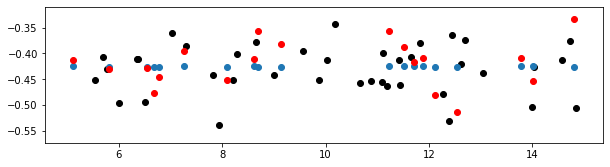

In [85]:
with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
    plt.scatter(pos[:, :39], tar[:, :39], c='black')
    plt.scatter(pos[:, 39:58], a[39:])
    plt.scatter(pos[:, 39:58], df_te[1, 39:58], c='red')

In [ ]:
# tf.data.Dataset(tf.Tensor(pad_pos_tr, value_index = 0 , dtype = tf.float32))